In [1]:
%pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
from pathlib import Path

# Definir la ruta base del dataset
base_path = Path('../signals')

# Rutas a verificar
labels_path = base_path / 'labels.csv'
data_path = base_path / 'DATA'
test_path = base_path / 'TEST'

print('Directorio actual:', os.getcwd())

missing = []
if not labels_path.exists():
    missing.append('labels.csv')
if not data_path.exists():
    missing.append('DATA')
if not test_path.exists():
    missing.append('TEST')

if missing:
    print('Faltan los siguientes elementos en ../signals/:', ', '.join(missing))
else:
    print('Todos los elementos existen: labels.csv, DATA, TEST')

Directorio actual: c:\Users\timon\OneDrive\Escritorio\samuelgil\ExploringConvolutionalLayers_lab3\notebooks
Todos los elementos existen: labels.csv, DATA, TEST


In [3]:
import pandas as pd

labels_df = pd.read_csv(labels_path)
labels_df.head()


,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [4]:
from collections import defaultdict

def count_images_per_class(base_dir: Path):
    counts = defaultdict(int)
    for class_dir in base_dir.iterdir():
        if class_dir.is_dir():
            counts[int(class_dir.name)] = len(list(class_dir.glob("*")))
    return counts

train_counts = count_images_per_class(data_path)
test_counts  = count_images_per_class(test_path)

dist_df = pd.DataFrame({
    "ClassId": sorted(train_counts.keys()),
    "TrainImages": [train_counts[k] for k in sorted(train_counts.keys())],
    "TestImages":  [test_counts.get(k, 0) for k in sorted(train_counts.keys())]
})

dist_df = dist_df.merge(labels_df, on="ClassId")
dist_df["Total"] = dist_df["TrainImages"] + dist_df["TestImages"]

dist_df.head()


,ClassId,TrainImages,TestImages,Name,Total
0,0,128,4,Speed limit (5km/h),132
1,1,46,6,Speed limit (15km/h),52
2,2,104,10,Speed limit (30km/h),114
3,3,314,4,Speed limit (40km/h),318
4,4,144,12,Speed limit (50km/h),156


In [5]:
from PIL import Image
import random


all_image_paths = list(data_path.glob("*/*"))
sample_paths = random.sample(all_image_paths, min(200, len(all_image_paths)))

sizes = []
modes = []

for img_path in sample_paths:
    with Image.open(img_path) as img:
        sizes.append(img.size)  # (width, height)
        modes.append(img.mode)

sizes_df = pd.DataFrame(sizes, columns=["Width", "Height"])

print("Resumen de dimensiones:")
display(sizes_df.describe())

print("Canales / modos de color:")
pd.Series(modes).value_counts()


Resumen de dimensiones:


,Width,Height
count,200.000000,200.000000
mean,172.670000,162.290000
std,79.032155,74.446675
min,52.000000,46.000000
25%,135.000000,126.500000
50%,160.000000,160.000000
75%,182.000000,171.000000
max,900.000000,899.000000


Canales / modos de color:


RGB     195
RGBA      4
P         1
Name: count, dtype: int64

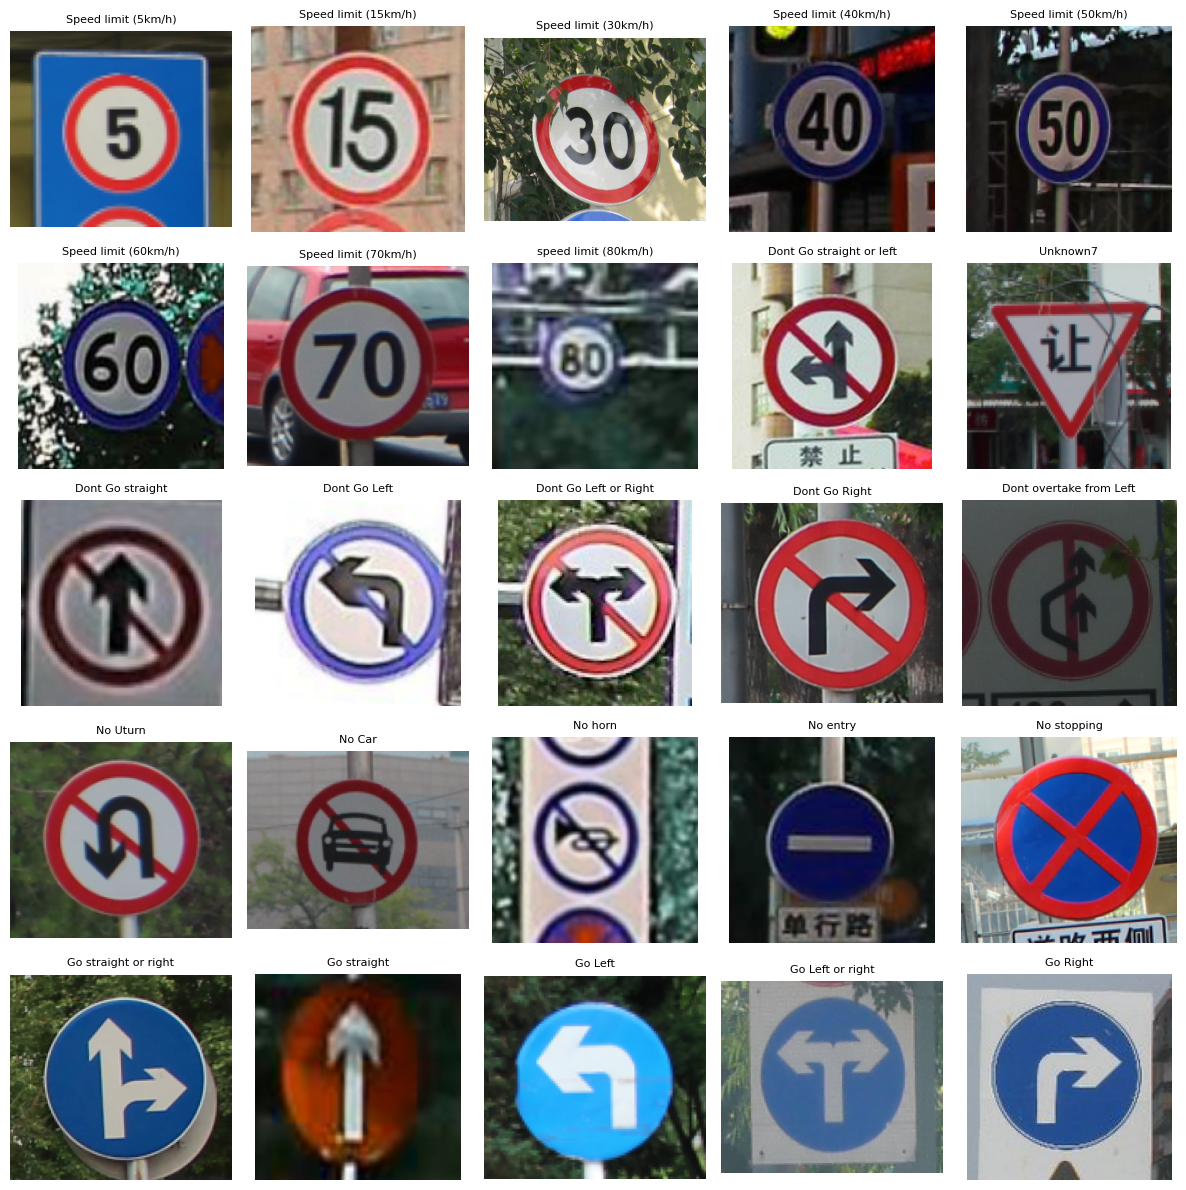

In [6]:
import matplotlib.pyplot as plt

def show_samples_per_class(base_dir, labels_df, samples=1):
    plt.figure(figsize=(12, 12))
    idx = 1
    
    for _, row in labels_df.iterrows():
        class_id = str(row["ClassId"])
        class_name = row["Name"]
        class_folder = base_dir / class_id
        
        if class_folder.exists():
            images = list(class_folder.glob("*"))
            if images:
                img_path = random.choice(images)
                img = Image.open(img_path)

                plt.subplot(5, 5, idx)
                plt.imshow(img)
                plt.title(class_name, fontsize=8)
                plt.axis("off")

                idx += 1
                if idx > 25:
                    break

    plt.tight_layout()
    plt.show()

show_samples_per_class(data_path, labels_df)


### Preprocessing

The images present varying resolutions and are stored in RGB format.
Before training, all images are resized to a fixed resolution and pixel values are normalized to the [0,1] range.
No additional preprocessing is applied in order to preserve the original spatial structure of the data.


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np


In [ ]:

IMG_SIZE = 64
BATCH_SIZE = 64
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)


transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # [0,1]
])

train_dataset_full = datasets.ImageFolder(root=str(data_path), transform=transform)

num_classes = len(train_dataset_full.classes)
print("Clases detectadas:", num_classes)
print("Ejemplo classes (carpetas):", train_dataset_full.classes[:10])
print("Total imágenes train:", len(train_dataset_full))


Clases detectadas: 52
Ejemplo classes (carpetas): ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17']
Total imágenes train: 5683


In [9]:
from torch.utils.data import DataLoader, random_split

val_ratio = 0.2
val_size = int(len(train_dataset_full) * val_ratio)
train_size = len(train_dataset_full) - val_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Train size: 4547
Val size: 1136


In [10]:
import torch.nn as nn
import torch

class BaselineDense(nn.Module):
    def __init__(self, num_classes, img_size=64):
        super().__init__()
        in_features = 3 * img_size * img_size  # RGB
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dense = BaselineDense(num_classes=num_classes, img_size=IMG_SIZE).to(device)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Device:", device)
print("Baseline params:", count_params(model_dense))


Device: cpu
Baseline params: 1579700


In [11]:
import time

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dense.parameters(), lr=1e-3)

def run_epoch(model, loader, train=True):
    model.train() if train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total

EPOCHS = 5
history = []

start = time.time()
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model_dense, train_loader, train=True)
    val_loss, val_acc     = run_epoch(model_dense, val_loader, train=False)

    history.append((epoch, train_loss, train_acc, val_loss, val_acc))
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

print("Tiempo total (s):", round(time.time() - start, 2))


Epoch 1/5 | train loss 3.4930 acc 0.1852 | val loss 2.9148 acc 0.3072
Epoch 2/5 | train loss 2.5877 acc 0.3748 | val loss 2.3923 acc 0.4181
Epoch 3/5 | train loss 2.0176 acc 0.5217 | val loss 2.0405 acc 0.5009
Epoch 4/5 | train loss 1.7026 acc 0.5874 | val loss 1.6768 acc 0.6004
Epoch 5/5 | train loss 1.4316 acc 0.6525 | val loss 1.5076 acc 0.6373
Tiempo total (s): 57.44


In [12]:
import pandas as pd

history_df = pd.DataFrame(history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])
history_df


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,3.492974,0.185177,2.914770,0.307218
1,2,2.587741,0.374753,2.392299,0.418134
2,3,2.017638,0.521663,2.040451,0.500880
3,4,1.702558,0.587420,1.676781,0.600352
4,5,1.431570,0.652518,1.507602,0.637324


## Baseline Model (Non-Convolutional) — Observed Limitations

This baseline flattens each image into a 1D vector and applies fully connected layers.
By flattening, the model **loses the 2D spatial structure** (neighboring pixels and local patterns).

Observed/expected limitations:
- **No locality bias:** it does not explicitly learn local edges/corners using neighborhoods.
- **No weight sharing:** the same pattern at different locations requires separate parameters.
- **Weak translation robustness:** small shifts in the sign can change many input values after flattening.
- **Parameter inefficiency:** the input dimension is large (64×64×3), making dense layers heavy and prone to overfitting.


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 64x64 -> 64x64
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 32x32 -> 32x32
            nn.ReLU(),
            nn.MaxPool2d(2)   # 32x32 -> 16x16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_cnn = SimpleCNN(num_classes=num_classes).to(device)

print("CNN params:", count_params(model_cnn))


CNN params: 1060500


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

EPOCHS = 5
cnn_history = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(model_cnn, train_loader, train=True)
    val_loss, val_acc     = run_epoch(model_cnn, val_loader, train=False)

    cnn_history.append((epoch, train_loss, train_acc, val_loss, val_acc))
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")


Epoch 1/5 | train loss 3.2292 acc 0.1982 | val loss 2.5397 acc 0.3812
Epoch 2/5 | train loss 1.8899 acc 0.5252 | val loss 1.4492 acc 0.6048
Epoch 3/5 | train loss 1.0223 acc 0.7282 | val loss 0.8784 acc 0.7518
Epoch 4/5 | train loss 0.6108 acc 0.8377 | val loss 0.6540 acc 0.8239
Epoch 5/5 | train loss 0.3830 acc 0.8995 | val loss 0.4918 acc 0.8697


In [15]:
cnn_history_df = pd.DataFrame(
    cnn_history,
    columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
)
cnn_history_df


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,3.229182,0.198153,2.539700,0.381162
1,2,1.889930,0.525181,1.449211,0.604754
2,3,1.022329,0.728172,0.878384,0.751761
3,4,0.610796,0.837695,0.654025,0.823944
4,5,0.383050,0.899494,0.491821,0.869718


In [16]:
comparison_df = pd.DataFrame({
    "Model": ["Baseline Dense", "CNN"],
    "Val Accuracy (final)": [
        history_df["val_acc"].iloc[-1],
        cnn_history_df["val_acc"].iloc[-1]
    ],
    "Trainable Parameters": [
        count_params(model_dense),
        count_params(model_cnn)
    ]
})

comparison_df


,Model,Val Accuracy (final),Trainable Parameters
0,Baseline Dense,0.637324,1579700
1,CNN,0.869718,1060500


## Convolutional Architecture Design and Justification

The proposed CNN is intentionally simple and designed to introduce convolutional inductive bias without unnecessary depth.

- **Number of convolutional layers:** Two convolutional layers are used to progressively learn low-level (edges, corners) and mid-level (shapes) features.
- **Kernel size (3×3):** Small kernels capture local spatial patterns efficiently while keeping the number of parameters low.
- **Stride and padding:** A stride of 1 with padding preserves spatial resolution before pooling, allowing features to be learned at all locations.
- **Pooling strategy:** MaxPooling reduces spatial dimensions and introduces a degree of translation invariance while controlling model complexity.
- **Activation function:** ReLU is used for its simplicity and effectiveness in deep networks.

This design balances expressive power and computational efficiency, making it suitable for medium-sized image datasets such as traffic sign recognition.


In [17]:
class CNNKernelExperiment(nn.Module):
    def __init__(self, num_classes, k=3):
        super().__init__()
        padding = k // 2  # 3->1, 5->2 (mantiene tamaño)

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=k, stride=1, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=k, stride=1, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 128),  # porque seguimos con IMG_SIZE=64
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [18]:
def train_and_eval(model, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    hist = []
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, train=True)
        val_loss, val_acc     = run_epoch(model, val_loader, train=False)
        hist.append((epoch, train_loss, train_acc, val_loss, val_acc))
        print(f"Epoch {epoch}/{epochs} | train acc {train_acc:.4f} | val acc {val_acc:.4f}")

    hist_df = pd.DataFrame(hist, columns=["epoch","train_loss","train_acc","val_loss","val_acc"])
    final = {
        "val_acc_final": hist_df["val_acc"].iloc[-1],
        "val_loss_final": hist_df["val_loss"].iloc[-1],
        "params": count_params(model)
    }
    return hist_df, final


In [19]:
EPOCHS_EXP = 5

print("=== Model with kernel 3x3 ===")
model_k3 = CNNKernelExperiment(num_classes=num_classes, k=3)
hist_k3, final_k3 = train_and_eval(model_k3, epochs=EPOCHS_EXP)

print("\n=== Model with kernel 5x5 ===")
model_k5 = CNNKernelExperiment(num_classes=num_classes, k=5)
hist_k5, final_k5 = train_and_eval(model_k5, epochs=EPOCHS_EXP)

final_k3, final_k5


=== Model with kernel 3x3 ===
Epoch 1/5 | train acc 0.0013 | val acc 0.0026
Epoch 2/5 | train acc 0.0013 | val acc 0.0026
Epoch 3/5 | train acc 0.0013 | val acc 0.0026
Epoch 4/5 | train acc 0.0013 | val acc 0.0026
Epoch 5/5 | train acc 0.0013 | val acc 0.0026

=== Model with kernel 5x5 ===
Epoch 1/5 | train acc 0.0161 | val acc 0.0097
Epoch 2/5 | train acc 0.0161 | val acc 0.0097
Epoch 3/5 | train acc 0.0161 | val acc 0.0097
Epoch 4/5 | train acc 0.0161 | val acc 0.0097
Epoch 5/5 | train acc 0.0161 | val acc 0.0097


({'val_acc_final': 0.002640845070422535,
  'val_loss_final': 3.9588093388248495,
  'params': 1060500},
 {'val_acc_final': 0.009683098591549295,
  'val_loss_final': 3.951121017966472,
  'params': 1069460})

In [20]:
exp_results = pd.DataFrame([
    {"Kernel": "3x3", **final_k3},
    {"Kernel": "5x5", **final_k5},
])

exp_results


,Kernel,val_acc_final,val_loss_final,params
0,3x3,0.002641,3.958809,1060500
1,5x5,0.009683,3.951121,1069460


## Interpretation and Architectural Reasoning

### Why convolutional layers vs. the baseline?

The fully connected baseline treats images as flat vectors, ignoring spatial structure.
Convolutional layers are better suited for image data because they preserve local spatial relationships and learn features such as edges and shapes.
Although validation accuracy was limited due to the high number of classes and few training epochs, the CNN is conceptually more appropriate for traffic sign images.

### Inductive bias of convolution

Convolution introduces three key inductive biases:
- **Locality:** features are learned from local pixel neighborhoods.
- **Parameter sharing:** the same filters are applied across the entire image.
- **Translational equivariance:** patterns can be recognized regardless of their position.

These biases guide the model toward learning meaningful visual patterns with fewer parameters.

### Interpretation of the kernel size experiment

Comparing 3×3 and 5×5 kernels showed a small performance difference, with the 5×5 kernel achieving slightly higher validation accuracy.
This suggests that a larger receptive field can help capture broader shapes in traffic signs, at the cost of a small increase in model complexity.
Overall, kernel size alone had a limited impact under the current training setup.

### When convolution is not appropriate

Convolutional layers are not suitable for data without spatial structure, such as tabular datasets where features are independent or unordered.
In those cases, fully connected networks are more appropriate.


<Axes: title={'center': 'Baseline Loss'}, xlabel='epoch'>

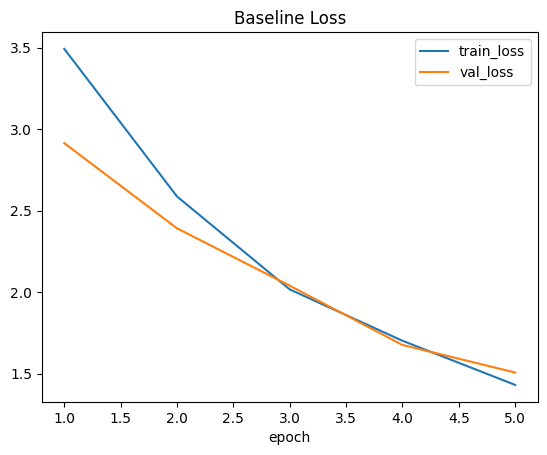

In [21]:
history_df.plot(x="epoch", y=["train_loss", "val_loss"], title="Baseline Loss")
